This module will perform

In [1]:
import pandas as pd
from neighborhood_reader import get_neighborhood, assign_neighborhood
from causalimpact import CausalImpact
import geopandas as gpd

## Step 1: Import data

In [2]:
df = pd.read_csv("../wa_collisions/data/Collisions_With_Neighborhoods.csv")

In [3]:
df.head(1).T

,0
Unnamed: 0,0
X,-122.342
Y,47.6276
objectid,162244138
inckey,233006
coldetkey,233406
addrtype,Block
collisiontype,Head On
exceptrsncode,
exceptrsndesc,NaN


In [4]:
df.columns

Index(['Unnamed: 0', 'X', 'Y', 'objectid', 'inckey', 'coldetkey', 'addrtype',
       'collisiontype', 'exceptrsncode', 'exceptrsndesc', 'fatalities',
       'inattentionind', 'incdate', 'incdttm', 'injuries', 'intkey',
       'junctiontype', 'lightcond', 'location', 'pedcount', 'pedcylcount',
       'pedrownotgrnt', 'personcount', 'reportno', 'roadcond', 'sdot_colcode',
       'sdot_coldesc', 'sdotcolnum', 'seriousinjuries', 'severitycode',
       'severitydesc', 'speeding', 'st_colcode', 'st_coldesc', 'status',
       'underinfl', 'vehcount', 'weather', 'seglanekey', 'crosswalkkey',
       'hitparkedcar', 'object_id'],
      dtype='object')

In [5]:
NEIGHBORHOODS = gpd.read_file('../wa_collisions/data/Neighborhoods/Neighborhoods.json')
NEIGHBORHOODS_COUNT = len(NEIGHBORHOODS)

## Step 2: Data clean-up

### Identify neighborhoods where speed limits changed

Identify neighborhoods where speed limit changed and those where it didn't

In [6]:
speed_limit_nbrhood = ['Atlantic','Pike-Market', 'Belltown', 'International District',
       'Central Business District', 'First Hill', 'Yesler Terrace',
       'Pioneer Square', 'Interbay','Mann','Minor']
no_speed_limit_nbrhood = list(set(NEIGHBORHOODS['S_HOOD'].unique()) - set(speed_limit_nbrhood))

Convert names to object ids

In [7]:
speed_limit_nbrhood_id = []
for i in range(0,len(speed_limit_nbrhood)):
    speed_limit_nbrhood_id = speed_limit_nbrhood_id + [int(NEIGHBORHOODS[NEIGHBORHOODS['S_HOOD'] == speed_limit_nbrhood[i]]['OBJECTID'])]
no_speed_limit_nbrhood = list(set(NEIGHBORHOODS['OBJECTID'].unique()) - set(speed_limit_nbrhood_id))

### Add speed limit flag to dataframe and group collisions data by date 

In [20]:
df['speedlimit_change_flag'] =  df['object_id'].isin(speed_limit_nbrhood_id)

In [24]:
df.head(1).T

,0
Unnamed: 0,0
X,-122.342
Y,47.6276
objectid,162244138
inckey,233006
coldetkey,233406
addrtype,Block
collisiontype,Head On
exceptrsncode,
exceptrsndesc,NaN


In [56]:
print('min date:',df['incdate'].min())
print('max date:',df['incdate'].max())

min date: 2003-10-06 00:00:00
max date: 2018-03-29 00:00:00


### Define periods before and after speed limit change

In [57]:
pre_period  = [pd.to_datetime(date) for date in ["2013-10-06", "2016-09-30"]]
post_period = [pd.to_datetime(date) for date in ["2016-10-01", "2018-03-29"]]

In [58]:
df['incdate'] = pd.to_datetime(df['incdate'])

### Create dataframe for input to causal impact

In [59]:
data_all = df.groupby(['incdttm','speedlimit_change_flag']).size()
data_all = data_all.unstack()
data_all = data_all.fillna(0)

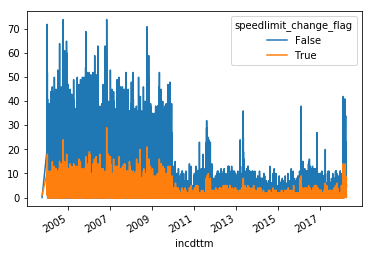

In [60]:
data_all.plot()

### Run causal impact

In [61]:
impact = CausalImpact(data_all, pre_period, post_period)
impact.run()

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [62]:
impact.summary()

                           Average         Cumulative
Actual                           1              14930
Predicted                        1              14828
95% CI                      [0, 2]    [-10512, 40169]
                                                     
Absolute Effect                  0                101
95% CI                     [1, -1]    [25442, -25239]
                                                     
Relative Effect               0.7%               0.7%
95% CI           [171.6%, -170.2%]  [171.6%, -170.2%]
